# Factors Driving Austin Housing Prices 
Ricardo Dunia
<br/>
Kevin John Cherian Joseph
<br/>
Arnob Mallick

In [1]:
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from scipy import stats
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
df = pd.read_csv('austin_housing_data.csv')

## Lets look at avg increase in house value from 2015 to 2019 per Zip Code

In [3]:
df_appraisal_inc_zip = df.groupby('zip', as_index=False)['5-year Growth'].mean()

import folium
from folium import plugins

df_appraisal_inc_zip['zip'] = df_appraisal_inc_zip['zip'].astype(int).astype('str')
df_appraisal_inc_zip['5-year Growth'] = df_appraisal_inc_zip['5-year Growth'].astype(float)

district_geo = r'austin_area_zip_codes.geojson'
map_choro = folium.Map(location=[30.285516,-97.736753 ],tiles='OpenStreetMap', zoom_start=9)

choroplethMap = folium.Choropleth(
    geo_data=district_geo,
    name='choropleth',
    data=df_appraisal_inc_zip,
    columns=['zip', '5-year Growth'],
    key_on='properties.zipcode',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Percentage Growth Over 5 years by Zip Code').add_to(map_choro)

folium.LayerControl().add_to(map_choro)

map_choro.save('PercentageGrowthOver5yearsbyZipCode.html')
map_choro

## Zip Code Wise House Price Appreciations

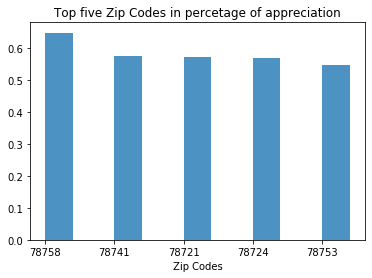

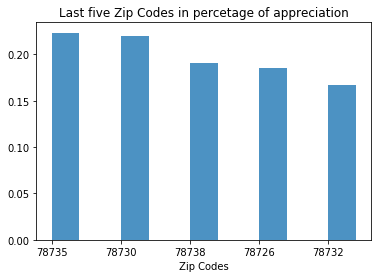

In [16]:
df_appraisal_inc_zip = df_appraisal_inc_zip.sort_values(by='5-year Growth',ascending=False)

df_top_zips = df_appraisal_inc_zip.head(5)
plt.bar(df_top_zips['zip'],df_top_zips['5-year Growth'], align='edge', alpha=0.8,width=0.4)
plt.xticks(df_top_zips['zip'])
plt.xlabel('Zip Codes')
plt.title('Top five Zip Codes in percetage of appreciation')

plt.show()

df_tail_zips = df_appraisal_inc_zip.tail(5)
plt.bar(df_tail_zips['zip'],df_tail_zips['5-year Growth'], align='edge', alpha=0.8,width=0.4)
plt.xticks(df_tail_zips['zip'])
plt.xlabel('Zip Codes')
plt.title('Last five Zip Codes in percetage of appreciation')

plt.show()

## Scale location sensitive data by Population Density

In [5]:
df['Crime Index Scaled'] = df['Crime Index'] / df['Population Density']
df['park_index_scaled'] = df['park_index'] / df['Population Density']
df['school_index_scaled'] = df['schools_index'] / df['Population Density']
df['event_index_scaled'] = df['event_index'] / df['Population Density']
df['fastfood_index_scaled'] = df['fastfood_index'] / df['Population Density']

In [6]:
df.describe()

,Unnamed: 0,daysOnMarket,hoa,latitude,longitude,lotSize,salePrice,pricePerSqFt,daysAftSold,sqFt,...,zip_78754.0,zip_78756.0,zip_78757.0,zip_78758.0,zip_78759.0,Crime Index Scaled,park_index_scaled,school_index_scaled,event_index_scaled,fastfood_index_scaled
count,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,2.438400e+04,24384.000000,24384.000000,24384.000000,...,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000
mean,40759.571891,2893.362164,18.437008,30.302651,-97.756544,9308.399278,3.130080e+05,161.580873,2900.362164,1982.975435,...,0.030635,0.025385,0.027928,0.026780,0.022433,49.021266,0.013374,0.012677,0.000602,0.014146
std,13850.949618,2205.981593,33.846092,0.086591,0.100770,7391.873708,2.071792e+05,89.377949,2205.981593,836.428433,...,0.172330,0.157296,0.164770,0.161443,0.148089,40.942693,0.008125,0.010714,0.001291,0.010443
min,2223.000000,2.000000,0.000000,30.100692,-98.015696,1189.000000,1.800000e+04,14.000000,9.000000,468.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30358.750000,965.000000,0.000000,30.235515,-97.836052,5793.000000,1.620000e+05,98.000000,972.000000,1346.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11.672669,0.006944,0.006775,0.000000,0.007023
50%,41794.500000,2396.000000,0.000000,30.308142,-97.739384,7535.000000,2.650000e+05,138.000000,2403.000000,1778.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,44.336461,0.012461,0.009159,0.000000,0.013514
75%,52611.250000,4563.750000,29.000000,30.368430,-97.689343,10062.000000,4.050000e+05,200.000000,4570.750000,2468.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,75.007187,0.018455,0.014136,0.000608,0.017441
max,61792.000000,8605.000000,600.000000,30.514585,-97.504938,65732.000000,2.340000e+06,619.000000,8612.000000,6000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,778.403427,0.090343,0.090343,0.007937,0.140187


## How does the cross-correlation matrix look?

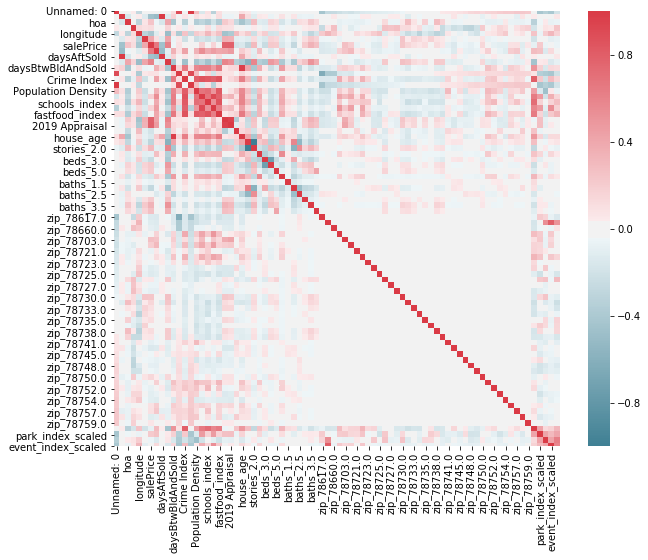

In [7]:
# examine the cross correlation matrix of the features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Try building a model to predict 5 Year Growth

In [8]:
# function for standardizing column names
def fix_column_names(df):
    cols = list(df)
    return df.rename(columns={ col: col.replace(' ', '_').lower() for col in cols })

# adjust skewness of data
df_temp = df.copy()
numeric_feats = df_temp.dtypes[df_temp.dtypes != "object"].index
numeric_feats = [ feat for feat in numeric_feats if 
    ('zip_' not in feat) and
    ('beds_' not in feat) and 
    ('baths_' not in feat) and 
    ('stories_' not in feat) ]
skewed_feats = df_temp[numeric_feats].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df_temp[skewed_feats] = np.log1p(df_temp[skewed_feats])
df_temp = df_temp[~df_temp.isin([np.inf, -np.inf])]
df_temp = df_temp.fillna(df_temp.mean())

# isolate the data into the train and test set with input and output features
excluded_feats = [
    'id', 'daysOnMarket', 'latitude', 'longitude', 'salePrice', 'daysAftSold', 'daysBtwBldAndSold',
    'Crime Index', 'idx', 'park_index', 'schools_index', 'event_index', 'fastfood_index', '2015 Appraisal',
    '2019 Appraisal', '5-year Growth', 'city', 'state', 'Number', 'Address', 'streetLine' ]
X = fix_column_names(df_temp.loc[:, [feat for feat in list(df_temp) if feat not in excluded_feats]])
y = fix_column_names(df_temp.loc[:, ['5-year Growth']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
skewed_feats

Index(['hoa', 'lotSize', 'salePrice', 'pricePerSqFt', 'sqFt',
       'daysBtwBldAndSold', 'Crime Index', 'park_index', 'event_index',
       '2015 Appraisal', '2019 Appraisal', '5-year Growth',
       'Crime Index Scaled', 'park_index_scaled', 'school_index_scaled',
       'event_index_scaled', 'fastfood_index_scaled'],
      dtype='object')

In [10]:
X.describe()

,unnamed:_0,hoa,lotsize,pricepersqft,sqft,zip,population_density,house_age,stories_1.0,stories_2.0,...,zip_78754.0,zip_78756.0,zip_78757.0,zip_78758.0,zip_78759.0,crime_index_scaled,park_index_scaled,school_index_scaled,event_index_scaled,fastfood_index_scaled
count,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,...,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000
mean,40759.571891,1.541338,8.969926,4.957727,7.508035,78729.835999,3166.364296,15915.830217,0.599779,0.400221,...,0.030635,0.025385,0.027928,0.026780,0.022433,3.237157,0.013253,0.012543,0.000601,0.013994
std,13850.949618,1.789486,0.530787,0.512919,0.412106,29.406570,2066.260152,8842.203927,0.489953,0.489953,...,0.172330,0.157296,0.164770,0.161443,0.148089,1.519717,0.007994,0.010429,0.001287,0.010212
min,2223.000000,0.000000,7.081709,2.708050,6.150603,78617.000000,252.000000,359.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30358.750000,0.000000,8.664578,4.595120,7.205635,78724.000000,1135.000000,8632.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.539447,0.006920,0.006752,0.000000,0.006998
50%,41794.500000,0.000000,8.927447,4.934474,7.483807,78736.000000,3240.000000,14343.500000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.814112,0.012384,0.009117,0.000000,0.013423
75%,52611.250000,3.401197,9.216621,5.303305,7.811568,78749.000000,4851.000000,21981.250000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.330828,0.018286,0.014037,0.000608,0.017290
max,61792.000000,6.398595,11.093356,6.429719,8.699681,78759.000000,7070.000000,62145.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,6.658529,0.086492,0.086492,0.007905,0.131192


## Train a simple linear regression model

In [11]:

regr = LinearRegression()
regr.fit(X_train, y_train)
regr_pred = regr.predict(X_test)
# Calculate the Root Mean Squared Error
rmse_regr = np.sqrt(mean_squared_error(y_test, regr_pred))
print("RMSE: %f" % (rmse_regr))

RMSE: 0.135952


## Train a various models

In [12]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

#following a kaggle notebook - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso_preds = lasso.fit(X_train, y_train).predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_preds))
print("Lasso RSME: %f" % rmse_lasso)

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet_preds = ENet.fit(X_train, y_train).predict(X_test)
rmse_ENet = np.sqrt(mean_squared_error(y_test, ENet_preds))
print("ElasticNet RSME: %f" % rmse_ENet)

#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
#KRR_preds = KRR.fit(X_train, y_train).predict(X_test)
#rmse_KRR = np.sqrt(mean_squared_error(y_test, KRR_preds))
#print("KRR RSME: %f" % rmse_KRR)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost_preds = GBoost.fit(X_train, y_train).predict(X_test)
rmse_GBoost = np.sqrt(mean_squared_error(y_test, GBoost_preds))
print("GBoost RSME: %f" % rmse_GBoost)

xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb_preds = xgb_model.fit(X_train, y_train).predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
print("XGB RSME: %f" % rmse_xgb)


Lasso RSME: 0.136807
ElasticNet RSME: 0.136635
GBoost RSME: 0.119971
XGB RSME: 0.121651


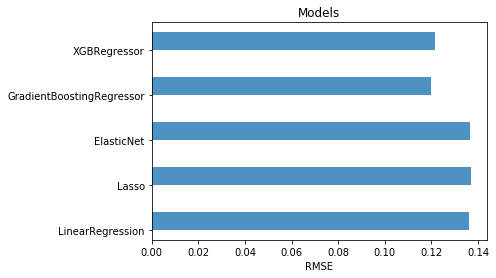

In [13]:


models = ('LinearRegression', 'Lasso', 'ElasticNet', 'GradientBoostingRegressor', 'XGBRegressor')
y_pos = np.arange(len(models))
performance = [rmse_regr,rmse_lasso,rmse_ENet,rmse_GBoost,rmse_xgb]

plt.barh(y_pos, performance, align='edge', alpha=0.8,height=0.4)
plt.yticks(y_pos, models)
plt.xlabel('RMSE')
plt.title('Models')

plt.show()